<a href="https://colab.research.google.com/github/wai-ming-chan/fed_avg/blob/main/sanityCheck_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo program to train MNIST with Pytorch (Centralized training)

Reference: [https://meinkappa.github.io/blog/2021/09/16/MNIST-In-Pytorch.html](https://meinkappa.github.io/blog/2021/09/16/MNIST-In-Pytorch.html)

In [11]:
# import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

#-----------------------------------------------------------------------
# libraries for pyTorch model Visualization
! pip install -q torchview
! pip install -q -U graphviz

import torchvision

from torchview import draw_graph
from torch import nn
import torch
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')
#-----------------------------------------------------------------------


'png'

### Loading dataset


device:  cpu
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
training data size:  60000
test data size:  10000
torch.Size([1, 28, 28])
torch.Size([28, 28])


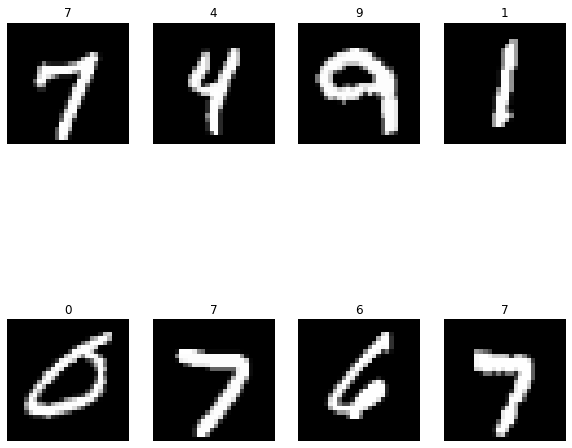

In [12]:
# grab MNIST data with torchvision datasets
## We can tell Pytorch how to manipulate the dataset by giving details.
##
### root: Where to store the data. We are storing it in data directory.
### train: Whether to grab training dataset or testing dataset. 
###         Given True value, training_data is a training dataset from MNIST. 
###         On the other hand, test_data is a testing dataset from MNIST.
### download: Whether to download if data is not already in root. We passed True to download the dataset.
### transform: What to do with data. We are converting our images of handwritten digits into Pytorch tensors so that we can train our model.

training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

# Set GPU or CPU device. If GPU is available, we use it to speed up the training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)

# check the dimension of data
print(training_data)
print('training data size: ', len(training_data) )
print('test data size: ', len(test_data) )
print(training_data[0][0].shape)
print(training_data[0][0].squeeze().shape)
# plt.imshow(training_data[len(training_data)-1][0].squeeze(), cmap="gray");
# print('label: ', training_data[len(training_data)-1][1])


figure = plt.figure(figsize=(10,10))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [13]:
# create a dataloader. 
## A dataloader divides our data by a given batch_size and hands out each one to our model for training
## Our train_dataloader will have 64 images per batch, which makes a total of 157 batches.
bs=64
train_dataloader = DataLoader(training_data, batch_size=bs)
test_dataloader = DataLoader(test_data, batch_size=bs)

print(10000/64, len(test_dataloader))


156.25 157


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Help on function summary in module torchsummary.torchsummary:

summary(model, input_size, batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [64, 784]               0
            Linear-2                  [64, 512]         401,920
              ReLU-3                  [64, 512]               0
            Linear-4                   [64, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.89
Params size (MB): 1.55
Estimated Total Size (MB): 2.63
-

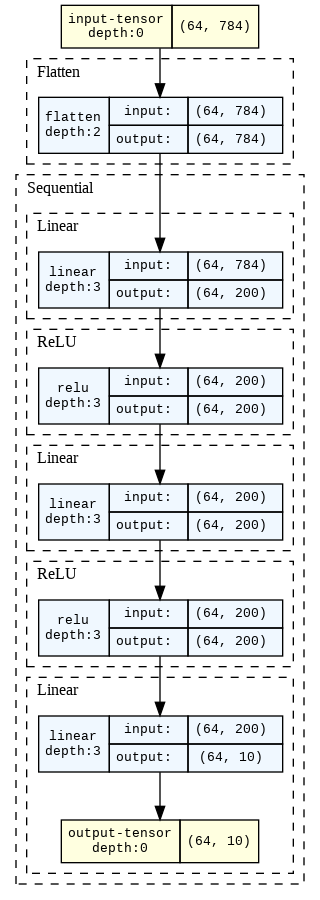

In [14]:
# setup our model now.

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Feed our model into GPU now if there is one.
model = NeuralNetwork().to(device)
# print(model)

from torchsummary import summary
help(summary)
# summary(model, input_size=(1,784), batch_size=bs)


# Model 1: 2NN
class MNIST_2NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_2NN = MNIST_2NN().to(device)
summary(model_2NN, input_size=(1,784), batch_size=bs)


model_graph = draw_graph(
  model_2NN, 
  input_size=(bs,784), 
  graph_name='my2NN',
  hide_inner_tensors=True,
  hide_module_functions=False,
  expand_nested=True,
  roll=True, # rolls recursive models
  save_graph=True
)
model_graph.visual_graph
#-----------------------------------------------------------------------

### Visualization of our defined models

In [15]:
if False:
  # Visualization of model and trace (method 1: Torchviz )
  ## ref: https://github.com/szagoruyko/pytorchviz
  !pip install torchviz
  from torchviz import make_dot

  # model = nn.Sequential()
  # model.add_module('W0', nn.Linear(8, 16))
  # model.add_module('tanh', nn.Tanh())
  # model.add_module('W1', nn.Linear(16, 1))
  # make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

  # x = torch.randn(1, 8)
  # y = model(x)
  # print('x: ', x)
  # print('y: ', y)

  model = NeuralNetwork().to(device)
  sample_idx = torch.randint(len(training_data), size=(1,)).item() # randomly pick one sample
  img, label = training_data[sample_idx]
  y = model(img)
  make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


In [16]:
if False:
  # Visualization of pyTorch model (method 2: torchview)
  # source: https://github.com/mert-kurttutan/torchview
  ! pip install -q torchview
  ! pip install -q -U graphviz

  import torchvision

  from torchview import draw_graph
  from torch import nn
  import torch
  import graphviz

  # when running on VSCode run the below command
  # svg format on vscode does not give desired result
  graphviz.set_jupyter_format('png')

  summary(model, input_size=(1,784), batch_size=64)

  batch_size=64
  model_graph = draw_graph(
    model, 
    input_size=(batch_size,784), 
    graph_name='myNN',
    hide_inner_tensors=True,
    hide_module_functions=False,
    expand_nested=True,
    roll=True, # rolls recursive models
    save_graph=True
  )
  model_graph.visual_graph


### Some model hyperparameters setting

In [19]:
# model parameters setting (will affect performance of the model)
lr = 1e-3     # learning rate
bs = 64       # batch size
epochs = 5    # more epochs the more likely our model is going to learn from the dataset. However, too many epochs will overfit our model

loss_fn = nn.CrossEntropyLoss() # Classificatin problem, we use Cross Entropy as loss function

optimizer = torch.optim.SGD(model_2NN.parameters(), lr=lr) # an optimizer to update our parameters, we use stochastic gradient descent to reduce the loss.



In [21]:
# define how we train our data
def train_data(model):
    for xb, yb in train_dataloader:   # fetch xb (a batch of images) and yb (a batch of labels) from train_dataloader
        preds = model(xb)             # make a prediction
        loss = loss_fn(preds, yb)     # compute the loss value
        optimizer.zero_grad()         # set our gradient to zero
        loss.backward()               # gradient descent
        optimizer.step()              # update our weights and biases
    loss = loss.item()
    print(f"Train loss: {loss:>7f}")




# define how we test our model
def test_data(model):
    num_batches = len(test_dataloader)
    size = len(test_dataloader.dataset)
    test_loss, corrects = 0, 0

    with torch.no_grad():             # Disabling gradient calculation for reduction of memory consumption for computations
        for xb, yb in test_dataloader:
            preds = model(xb)
            test_loss += loss_fn(preds, yb).item()
            corrects += (preds.argmax(1) == yb).type(torch.float).sum().item()
    
    test_loss /= num_batches
    # test_loss = lo
    corrects /= size
    print(f"Test loss: \n Accuracy: {(100*corrects):>0.1f}%, Avg loss: {test_loss:>8f} \n")


for t in range(1000):
  print('epoch: ', t)
  train_data(model_2NN)
  test_data(model_2NN)

epoch:  0
Train loss: 0.254169
Test loss: 
 Accuracy: 89.0%, Avg loss: 0.393770 

epoch:  1
Train loss: 0.243668
Test loss: 
 Accuracy: 89.1%, Avg loss: 0.384797 

epoch:  2
Train loss: 0.234236
Test loss: 
 Accuracy: 89.4%, Avg loss: 0.376841 

epoch:  3
Train loss: 0.225685
Test loss: 
 Accuracy: 89.4%, Avg loss: 0.369722 

epoch:  4
Train loss: 0.217895
Test loss: 
 Accuracy: 89.6%, Avg loss: 0.363298 

epoch:  5
Train loss: 0.210764
Test loss: 
 Accuracy: 89.8%, Avg loss: 0.357460 

epoch:  6
Train loss: 0.204199
Test loss: 
 Accuracy: 90.0%, Avg loss: 0.352107 

epoch:  7
Train loss: 0.198073
Test loss: 
 Accuracy: 90.1%, Avg loss: 0.347172 

epoch:  8
Train loss: 0.192319
Test loss: 
 Accuracy: 90.3%, Avg loss: 0.342598 

epoch:  9
Train loss: 0.186886
Test loss: 
 Accuracy: 90.3%, Avg loss: 0.338328 

epoch:  10
Train loss: 0.181833
Test loss: 
 Accuracy: 90.4%, Avg loss: 0.334325 

epoch:  11
Train loss: 0.177157
Test loss: 
 Accuracy: 90.5%, Avg loss: 0.330563 

epoch:  12
Tra

KeyboardInterrupt: ignored